#Assignment 2
Ben Hawks - z1849064 - CSCI490 Applied Machine Learning


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

data = pd.read_excel("http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls",na_values="",keep_default_na=False, index_col='Order')
#keep_na false + na_values = "" set to fill the empty spaces but not remove entries where NA is a valid catagory


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


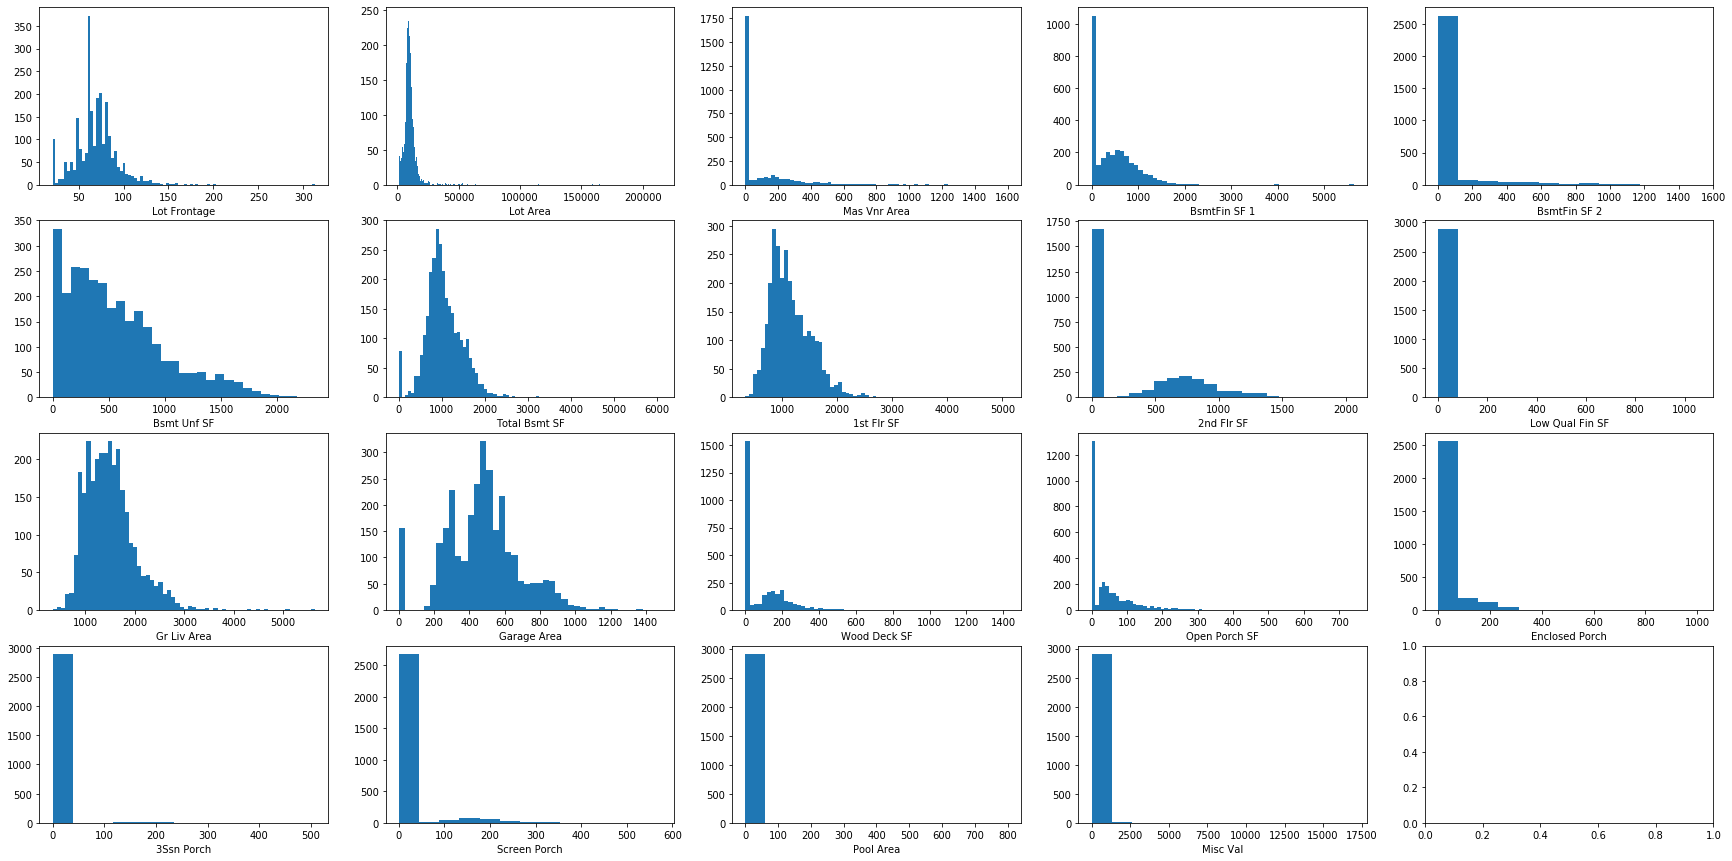

In [187]:
cont_cols = ["Lot Frontage","Lot Area","Mas Vnr Area","BsmtFin SF 1",
             "BsmtFin SF 2","Bsmt Unf SF","Total Bsmt SF",
             "1st Flr SF","2nd Flr SF","Low Qual Fin SF",
             "Gr Liv Area","Garage Area","Wood Deck SF",
             "Open Porch SF","Enclosed Porch","3Ssn Porch",
             "Screen Porch", "Pool Area","Misc Val"] #continuous values
nom_cols = ["MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", 
            "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", 
            "House Style", "Roof Style","Roof Matl", "Exterior 1st",
            "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating",
            "Central Air", "Garage Type",  "Misc Feature", "Sale Type",
            "Sale Condition"] #nominal values
ord_cols = ["Lot Shape","Utilities","Land Slope",
            "Exter Qual","Exter Cond","Bsmt Qual",
            "Bsmt Cond","Bsmt Exposure","BsmtFin Type 1","BsmtFin Type 2",
            "Heating QC","Electrical","Kitchen Qual","Functional","Fireplace Qu",
            "Garage Finish","Garage Qual","Garage Cond","Paved Drive",
            "Pool QC","Fence"] # ordinal values (scale but in whole steps)
disc_cols = ["Year Built","Year Remod/Add","Bsmt Full Bath", "Overall Cond",
             "Bsmt Half Bath","Full Bath","Half Bath","Bedroom AbvGr",
             "Kitchen AbvGr","TotRms AbvGrd","Fireplaces","Garage Yr Blt",
             "Garage Cars","Mo Sold","Overall Qual","Yr Sold"] # discrete vals
cont_fig, cont_ax =  plt.subplots(4,5,figsize=(30,15))
for col in cont_cols:
  crow = cont_cols.index(col)//5
  ccol = cont_cols.index(col)%5
  cont_ax[crow,ccol].hist(data[col],bins="auto")
  cont_ax[crow,ccol].set_xlabel(col)
plt.show()
data[ord_cols] = data[ord_cols].replace(np.nan,"Mis")
data[nom_cols] = data[nom_cols].replace(np.nan,"")

Question 2: Plotting all continuous features vs Sale Price

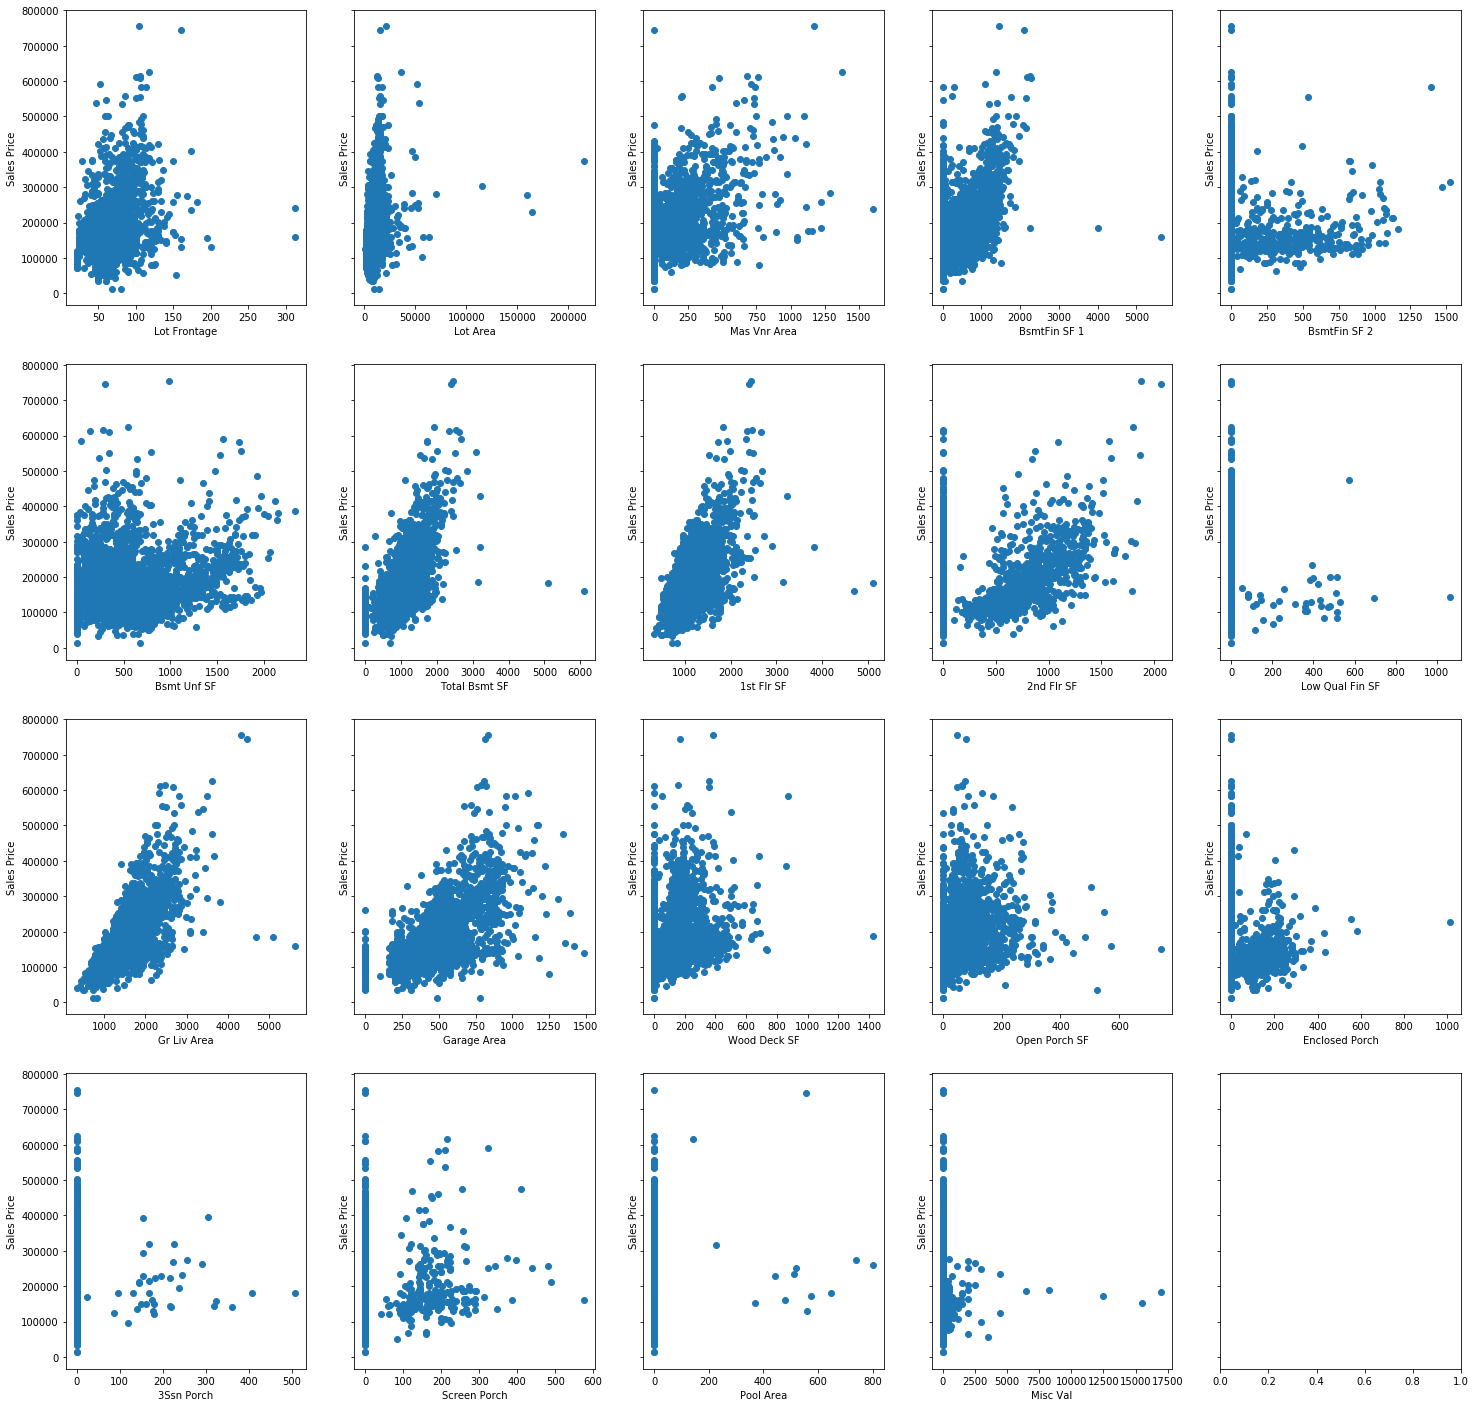

In [188]:
target_fig, target_ax = plt.subplots(4,5,figsize=(25,25),sharey=True, sharex=False) #Feature vs Target
for col in cont_cols:
  crow = cont_cols.index(col)//5
  ccol = cont_cols.index(col)%5
  target_ax[crow,ccol].scatter(data[col],data["SalePrice"])
  target_ax[crow,ccol].set_xlabel(col)
  target_ax[crow,ccol].set_ylabel("Sales Price")
plt.show()

Not every feature here has a clear relationship with our target. Though, there are a few values that do. Notably: Masonry veneer type, Basement Type 1 finished square feet, Total Basement Sq Footage, 1st/2nd floor square feet, general living area square footage, and garage area square footage. This seems to show that the biggest indicators of a house's price is related to the actual area of the house and it's rooms. Which intuitively seems logical

Question 3: Splitting data and finding Nominal feature with highest R2

R2 for MS Zoning: 0.10522240550763368
R2 for Street: -0.0015467060910044773
R2 for Alley: 0.013668609122793537
R2 for Land Contour: 0.03830095068942208
R2 for Lot Config: 0.007571219841313948
R2 for Neighborhood: -6.635300604710493e+22
R2 for Condition 1: 0.0301047843185932
R2 for Condition 2: -1.767373861102638e+24
R2 for Bldg Type: 0.022050147425696717
R2 for House Style: 0.06462266989384184
R2 for Roof Style: 0.04646100078643469
R2 for Roof Matl: -4.3038031218050134e+24
R2 for Exterior 1st: -1.1911142337195382e+23
R2 for Exterior 2nd: -5.6525807964492707e+20
R2 for Mas Vnr Type: 0.19054353066728566
R2 for Foundation: 0.2778831062536741
R2 for Heating: -1.85096495784395e+23
R2 for Central Air: 0.06331957696082854
R2 for Garage Type: 0.24882906754624212
R2 for Misc Feature: -7.8727811852037e+22
R2 for Sale Type: 0.13740752102844644
R2 for Sale Condition: 0.12670671549056264
------------------------> Highest R2 was Foundation with a value of 0.2778831062536741
223


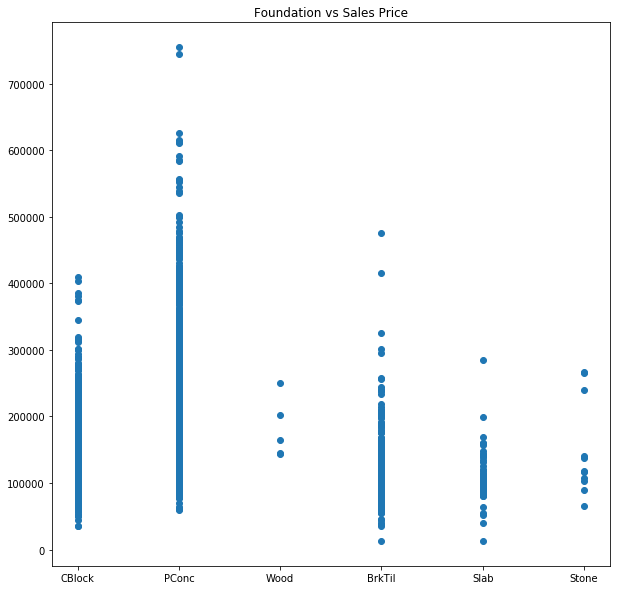

In [189]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.impute import KNNImputer, SimpleImputer

#Splitting our data! 
test_ratio = 0.30 #mess with this as we please, currently doing a 70/30 split of train/test
x_train,x_test,y_train,y_test = train_test_split(data.drop(columns=["PID","SalePrice"], inplace=False),data["SalePrice"],test_size=test_ratio) 
#splitting before our loop to, well, not poison our model with rng shenanigans,
#because I have no idea how the split is actually done, and don't trust it other

high_r2 = 0
high_r2_col = ""
all_feats = x_train.columns.to_list()
for col in nom_cols:
  col_ind = all_feats.index(col)
  all_feats.remove(col)
  x_ohe = pd.get_dummies(x_train[col],col)
  all_feats[col_ind:col_ind] = x_ohe
  r2 = np.mean(cross_val_score(LinearRegression(),x_ohe,y_train, cv=25, scoring="r2"))
  if r2 >= high_r2:
    high_r2 = r2
    high_r2_col = col
  print("R2 for " + col + ": " + str(r2))
print("------------------------> Highest R2 was " + high_r2_col + " with a value of " + str(high_r2))
r2_fig ,r2_ax = plt.subplots(1,1,figsize=(10,10))
r2_ax.scatter(data[high_r2_col],data["SalePrice"])
r2_ax.set_xticks(data[high_r2_col].unique())
r2_ax.set_title(high_r2_col + " vs Sales Price")
print(len(all_feats))


After running, Foundation seems to be the feature with the highest R2 score, an interested and somewhat unexpected result. 

Occationally Neighborbood shows up as highest with an R2 of almost double? ~.55 vs the ~.26 that Foundation hovers near, but Neighborhood only ends up as the top R2 score something like ~1/10 runs, very weird, potentially due to the randomness of the shuffle split that train_test_split is doing? Might be bad if so, but will "go with" Foundation as the actual picked feature due to consistency :/


Up until now no values have been imputed since this has mostly been Feature Engineering work, at this point we will impute values for the sake of building a more complete model.

Problem 4: Using ColumnTransformer and Pipeline on our nominal values, and seeing how the different models perform, along with the effects of StandardScaler

In [190]:
##print(x_train.describe)
#nans = {}
##for feature in ord_cols:
#  nans[feature] = [val for val in x_train[feature] if np.isnan(val)]
#print(nans)

ord_cat = {'Lot Shape': ['Reg', 'IR1', 'IR2', 'IR3'],
  'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
  'Land Slope': ['Sev', 'Mod', 'Gtl'],
  'Exter Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Exter Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Bsmt Qual': ['Mis', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Bsmt Cond': ['Mis', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Bsmt Exposure': ['Mis', 'NA', 'No', 'Mn', 'Av', 'Gd'],
  'BsmtFin Type 1': ['Mis', 'NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
  'BsmtFin Type 2': ['Mis', 'NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
  'Heating QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Electrical': ['Mis', 'SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
  'Kitchen Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
  'Fireplace Qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Garage Finish': ['Mis', 'NA', 'Unf', 'RFn', 'Fin'],
  'Garage Qual': ['Mis', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Garage Cond': ['Mis', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
  'Paved Drive': ['N', 'P', 'Y'],
  'Pool QC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
  'Fence': ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']}
catlist = [ord_cat[feature] for feature in ord_cols] #List of all ordinal values for use with ordinal Encoder, Mis (missing) is included to 

scaler_list = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler()]
for scaler in scaler_list:
  print("Evaluating Models using: " + str(scaler))
  disc_transformer = Pipeline(steps=[('imputer', KNNImputer())])
  disc_scaled_transformer = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', scaler)])

  cont_transformer = Pipeline(steps=[('imputer', KNNImputer())])
  cont_scaled_transformer = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', scaler)])

  nom_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown="ignore"))])

  ord_transformer = Pipeline(steps=[('ordencode', OrdinalEncoder(categories=catlist))])

  unscaled_preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_transformer, cont_cols),
        ("disc", disc_transformer, disc_cols),
        ("nom", nom_transformer, nom_cols),
        ("ord", ord_transformer, ord_cols)],
        remainder='passthrough')
  # print(unscaled_preprocessor.fit_transform(x_train,y_train))
  scaled_preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_scaled_transformer, cont_cols),
        ("disc", disc_scaled_transformer, disc_cols),
        ("nom", nom_transformer, nom_cols),
        ("ord", ord_transformer, ord_cols)],
        remainder='passthrough')
  
  linear_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', RidgeCV(alphas=[0.00001]))])
  linear_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', RidgeCV(alphas=[0.00001]))])

  ridge_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', RidgeCV())])
  ridge_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', RidgeCV())])

  lasso_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', LassoCV())])
  lasso_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', LassoCV())])

  elastic_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', ElasticNetCV())])
  elastic_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', ElasticNetCV())])

  models = {"linear_unscaled":linear_unscaled,"linear_scaled":linear_scaled,
            "ridge_unscaled":ridge_unscaled,"ridge_scaled":ridge_scaled,
            "lasso_unscaled":lasso_unscaled,"lasso_scaled":lasso_scaled,
            "elastic_unscaled":elastic_unscaled,"elastic_scaled":elastic_scaled}
  high_r2 = -1e+30 #big, big negitive value for init
  high_r2_model = ""
  for model in models:
    #print("Fitting model: " + model + "...")
    models[model].fit(x_train,y_train)
    r2 = np.mean(cross_val_score(models[model],x_train,y_train, cv=25, scoring="r2"))
    if r2 >= high_r2:
      high_r2 = r2
      high_r2_model = model
    print("Score for " + model + " " + str(r2)) 
  print("-----------------------------------------------> Best performing model using " + str(scaler)+ "was " + high_r2_model + " with a r2 score of " + str(high_r2))

Evaluating Models using: StandardScaler(copy=True, with_mean=True, with_std=True)
Score for linear_unscaled -3.6348177306495195
Score for linear_scaled 0.8476529974587208
Score for ridge_unscaled 0.8434602437544981
Score for ridge_scaled 0.8436477640507444
Score for lasso_unscaled 0.7357648811383108
Score for lasso_scaled 0.848139883599482
Score for elastic_unscaled 0.6227943642634329
Score for elastic_scaled 0.05667737262158541
-----------------------------------------------> Best performing model using StandardScaler(copy=True, with_mean=True, with_std=True)was lasso_scaled with a r2 score of 0.848139883599482
Evaluating Models using: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
Score for linear_unscaled -3.6348177306495195
Score for linear_scaled 0.8445109947262027
Score for ridge_unscaled 0.8434602437544981
Score for ridge_scaled 0.8429482655120151
Score for lasso_unscaled 0.7357648811383108
Score for lasso_scaled 0.83551

Overall, the scaling seems to help across the board for everything but ElasticNet, every scaler (tested more than StandardScaler out of my own curiousity) improves the score vs unscaled data, with most scalers resulting in close to the same accuracy on the *best* model, differing by a few percent.  

In [191]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet #Non-CV versions since we're using GridSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #ignore these warnings since we're literally testing how these models perform already, I dont need console spam regarding performance degredation 
warnings.filterwarnings(action='ignore', category=LinAlgWarning) 

grid_models = {}
scaler_list = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler()]
for scaler in scaler_list:
  disc_transformer = Pipeline(steps=[('imputer', KNNImputer())])
  disc_scaled_transformer = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', scaler)])

  cont_transformer = Pipeline(steps=[('imputer', KNNImputer())])
  cont_scaled_transformer = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', scaler)])

  nom_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown="ignore"))])

  ord_transformer = Pipeline(steps=[('ordencode', OrdinalEncoder(categories=catlist))])

  unscaled_preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_transformer, cont_cols),
        ("disc", disc_transformer, disc_cols),
        ("ord", ord_transformer, ord_cols),
        ("nom", nom_transformer, nom_cols)],
        remainder='passthrough')
  # print(unscaled_preprocessor.fit_transform(x_train,y_train))
  scaled_preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_scaled_transformer, cont_cols),
        ("disc", disc_scaled_transformer, disc_cols),
        ("ord", ord_transformer, ord_cols),
        ("nom", nom_transformer, nom_cols)],
        remainder='passthrough')
  
  ridge_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', Ridge())])
  ridge_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', Ridge())])

  lasso_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', Lasso())])
  lasso_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', Lasso())])

  elastic_unscaled = Pipeline(steps=[('column_transform', unscaled_preprocessor), ('classifier', ElasticNet())])
  elastic_scaled = Pipeline(steps=[('column_transform', scaled_preprocessor), ('classifier', ElasticNet())])

  C = np.array([0.01,0.1,1,10,100,1000])
  a = np.array([0.01,0.1,1,10,100,1000])
  a = np.array([0.0001,0.001,0.1,1,10,100,1000])

  models_ncv = { "ridge_unscaled":ridge_unscaled,"ridge_scaled":ridge_scaled, #No linreg because there are no parameters to optimize
            "lasso_unscaled":lasso_unscaled,"lasso_scaled":lasso_scaled,
            "elastic_unscaled":elastic_unscaled,"elastic_scaled":elastic_scaled}

  model_params = {"ridge_unscaled":{'classifier__alpha':a},"ridge_scaled":{'classifier__alpha':a},
            "lasso_unscaled":{'classifier__C':C},"lasso_scaled":{'classifier__C':C},
            "elastic_unscaled":{'classifier__alpha':a},"elastic_scaled":{'classifier__alpha':a}}

  scaler_str = str(scaler).split('(')[0]
  grid_models.update({scaler_str:{}})

  for model in models_ncv:
      model_str = str(model).split('(')[0]
      print("Fitting model: " + model + "...")
      model_obj = GridSearchCV(estimator=models_ncv[model],param_grid={'classifier__alpha':a},scoring='r2',cv=10)
      model_obj.fit(x_train,y_train)
      grid_models[scaler_str].update({model_str:model_obj})
      r2 = grid_models[scaler_str][model_str].best_score_
      if r2 >= high_r2:
        high_r2 = r2
        high_r2_model = model
      print("Best Params for " + model_str + " are " + str(grid_models[scaler_str][model_str].best_params_))
      print("Score for " + model_str + " " + str(r2)) 
  print("-----------------------------------------------> Best performing model using " + str(scaler)+ "was " + high_r2_model + " with a r2 score of " + str(high_r2))

Fitting model: ridge_unscaled...
Best Params for ridge_unscaled are {'classifier__alpha': 10.0}
Score for ridge_unscaled 0.8353190296430046
Fitting model: ridge_scaled...
Best Params for ridge_scaled are {'classifier__alpha': 10.0}
Score for ridge_scaled 0.8360125146320975
Fitting model: lasso_unscaled...
Best Params for lasso_unscaled are {'classifier__alpha': 10.0}
Score for lasso_unscaled 0.8427976994289057
Fitting model: lasso_scaled...
Best Params for lasso_scaled are {'classifier__alpha': 10.0}
Score for lasso_scaled 0.843027843071412
Fitting model: elastic_unscaled...
Best Params for elastic_unscaled are {'classifier__alpha': 0.001}
Score for elastic_unscaled 0.8336678544766155
Fitting model: elastic_scaled...
Best Params for elastic_scaled are {'classifier__alpha': 0.001}
Score for elastic_scaled 0.833750825721976
-----------------------------------------------> Best performing model using StandardScaler(copy=True, with_mean=True, with_std=True)was lasso_scaled with a r2 score 

Lasso Scaled (using any scaler) seemed to be the best model in our grid search, though only by a few percentage points!

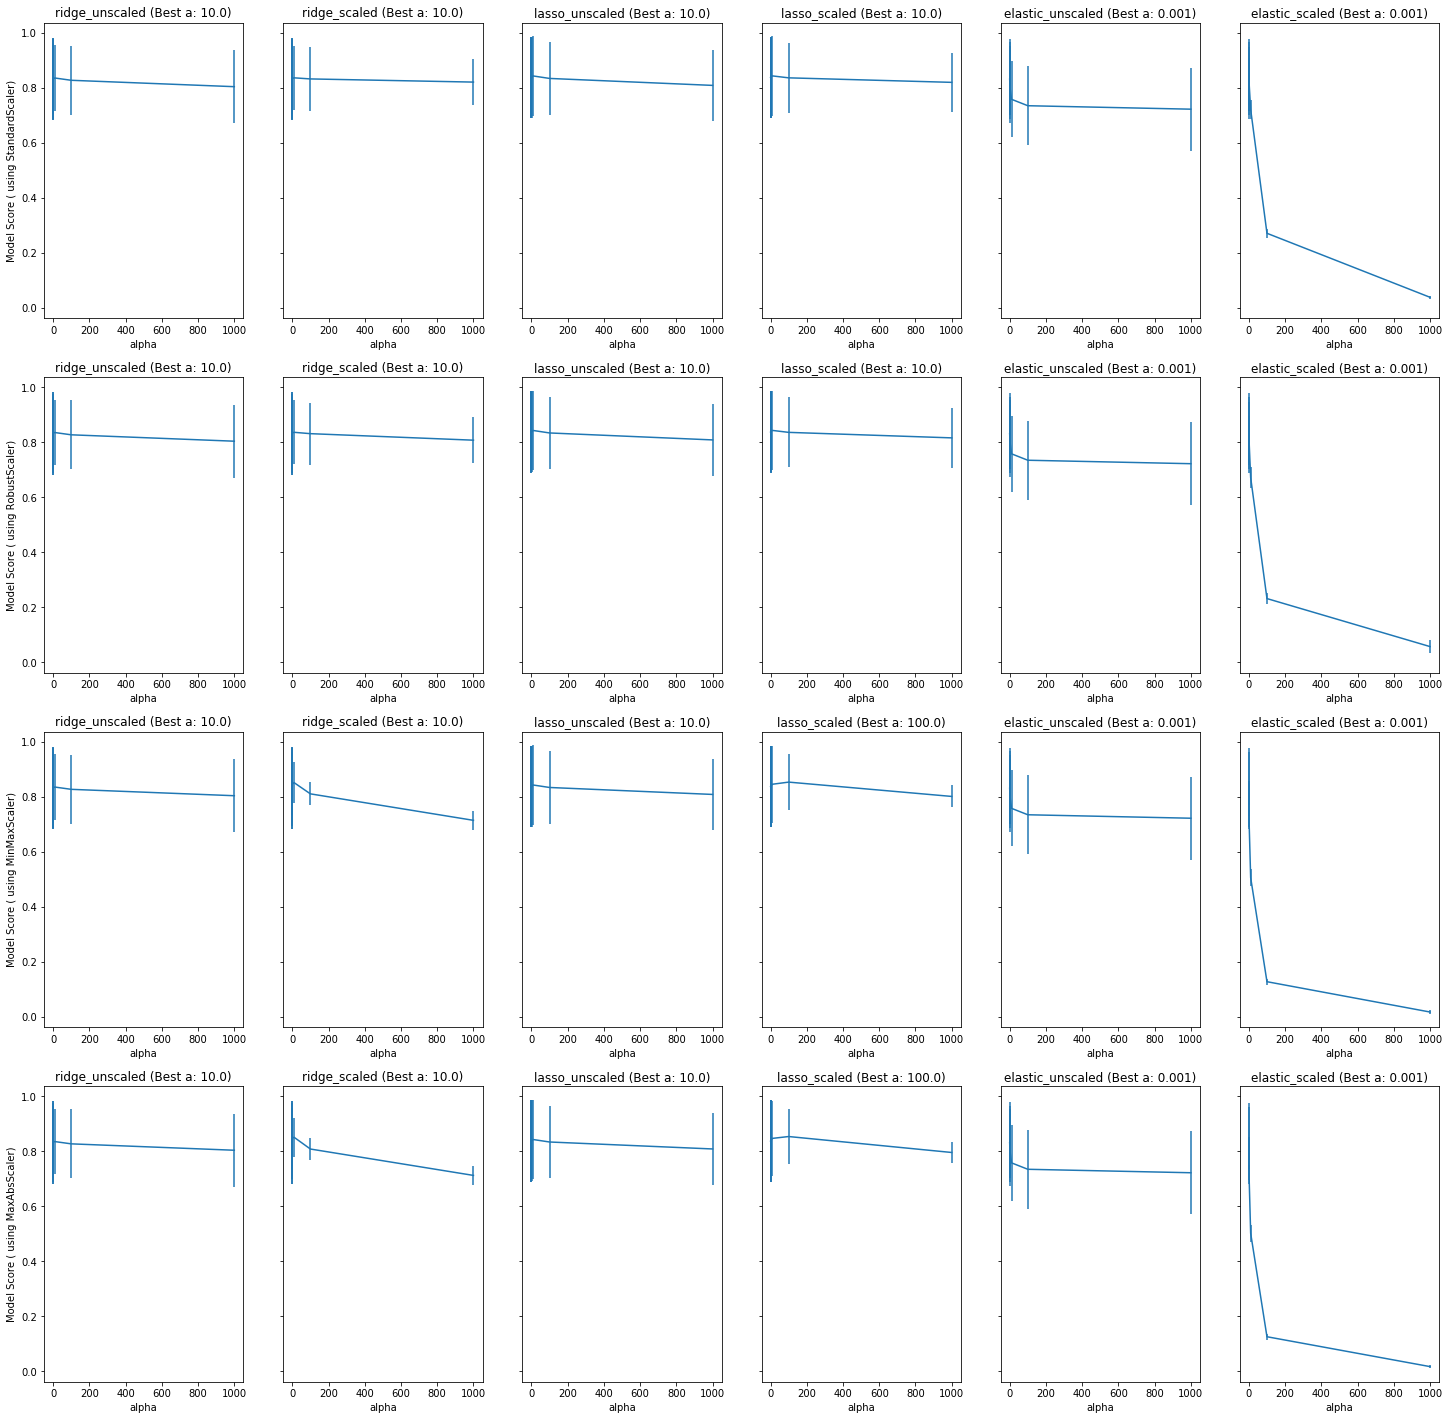

In [199]:
grid_models = pd.DataFrame.from_dict(grid_models)
rowcnt = len(grid_models.index)
colcnt = len(grid_models.columns)

alpha_fig, alpha_ax = plt.subplots(colcnt,rowcnt,figsize=(25,25),sharey=True, sharex=False) #Alpha vs score

grid_models = pd.DataFrame.from_dict(grid_models)

r = 0
for scaler_str in grid_models:
  c = 0
  for model in grid_models[scaler_str]:
    crow = r #this is a bit less 'elegant' than how I do it above, but 1000x easier since I'm now working with a dataframe (which has other benifits here)
    ccol = c 
    alphas = model.cv_results_['param_classifier__alpha']
    scores = model.cv_results_['mean_test_score'] 
    scores_err = model.cv_results_['std_test_score'] 
    alpha_ax[crow,ccol].errorbar(alphas,scores,scores_err)
    alpha_ax[crow,ccol].set_xlabel("alpha")
    if c ==0:
      alpha_ax[crow,ccol].set_ylabel("Model Score ( using " + scaler_str + ")")
    alpha_ax[crow,ccol].set_title(label=grid_models.index.values[c] + " (Best a: " + str(model.best_params_['classifier__alpha']) + ")")
    c +=1
  r += 1 
plt.show()

Grid searching the parameter Alpha for these models helped a small amount, < 1% in most cases. Alpha vs r2 does show that the score of the model tends to decrease as the alpha increases, but because the default values of Alpha tend to be somewhat small as it is, there wasn't a lot of improvement shown in grid searching 

Question 6: Visualizing Coeffficents of the resulting models 

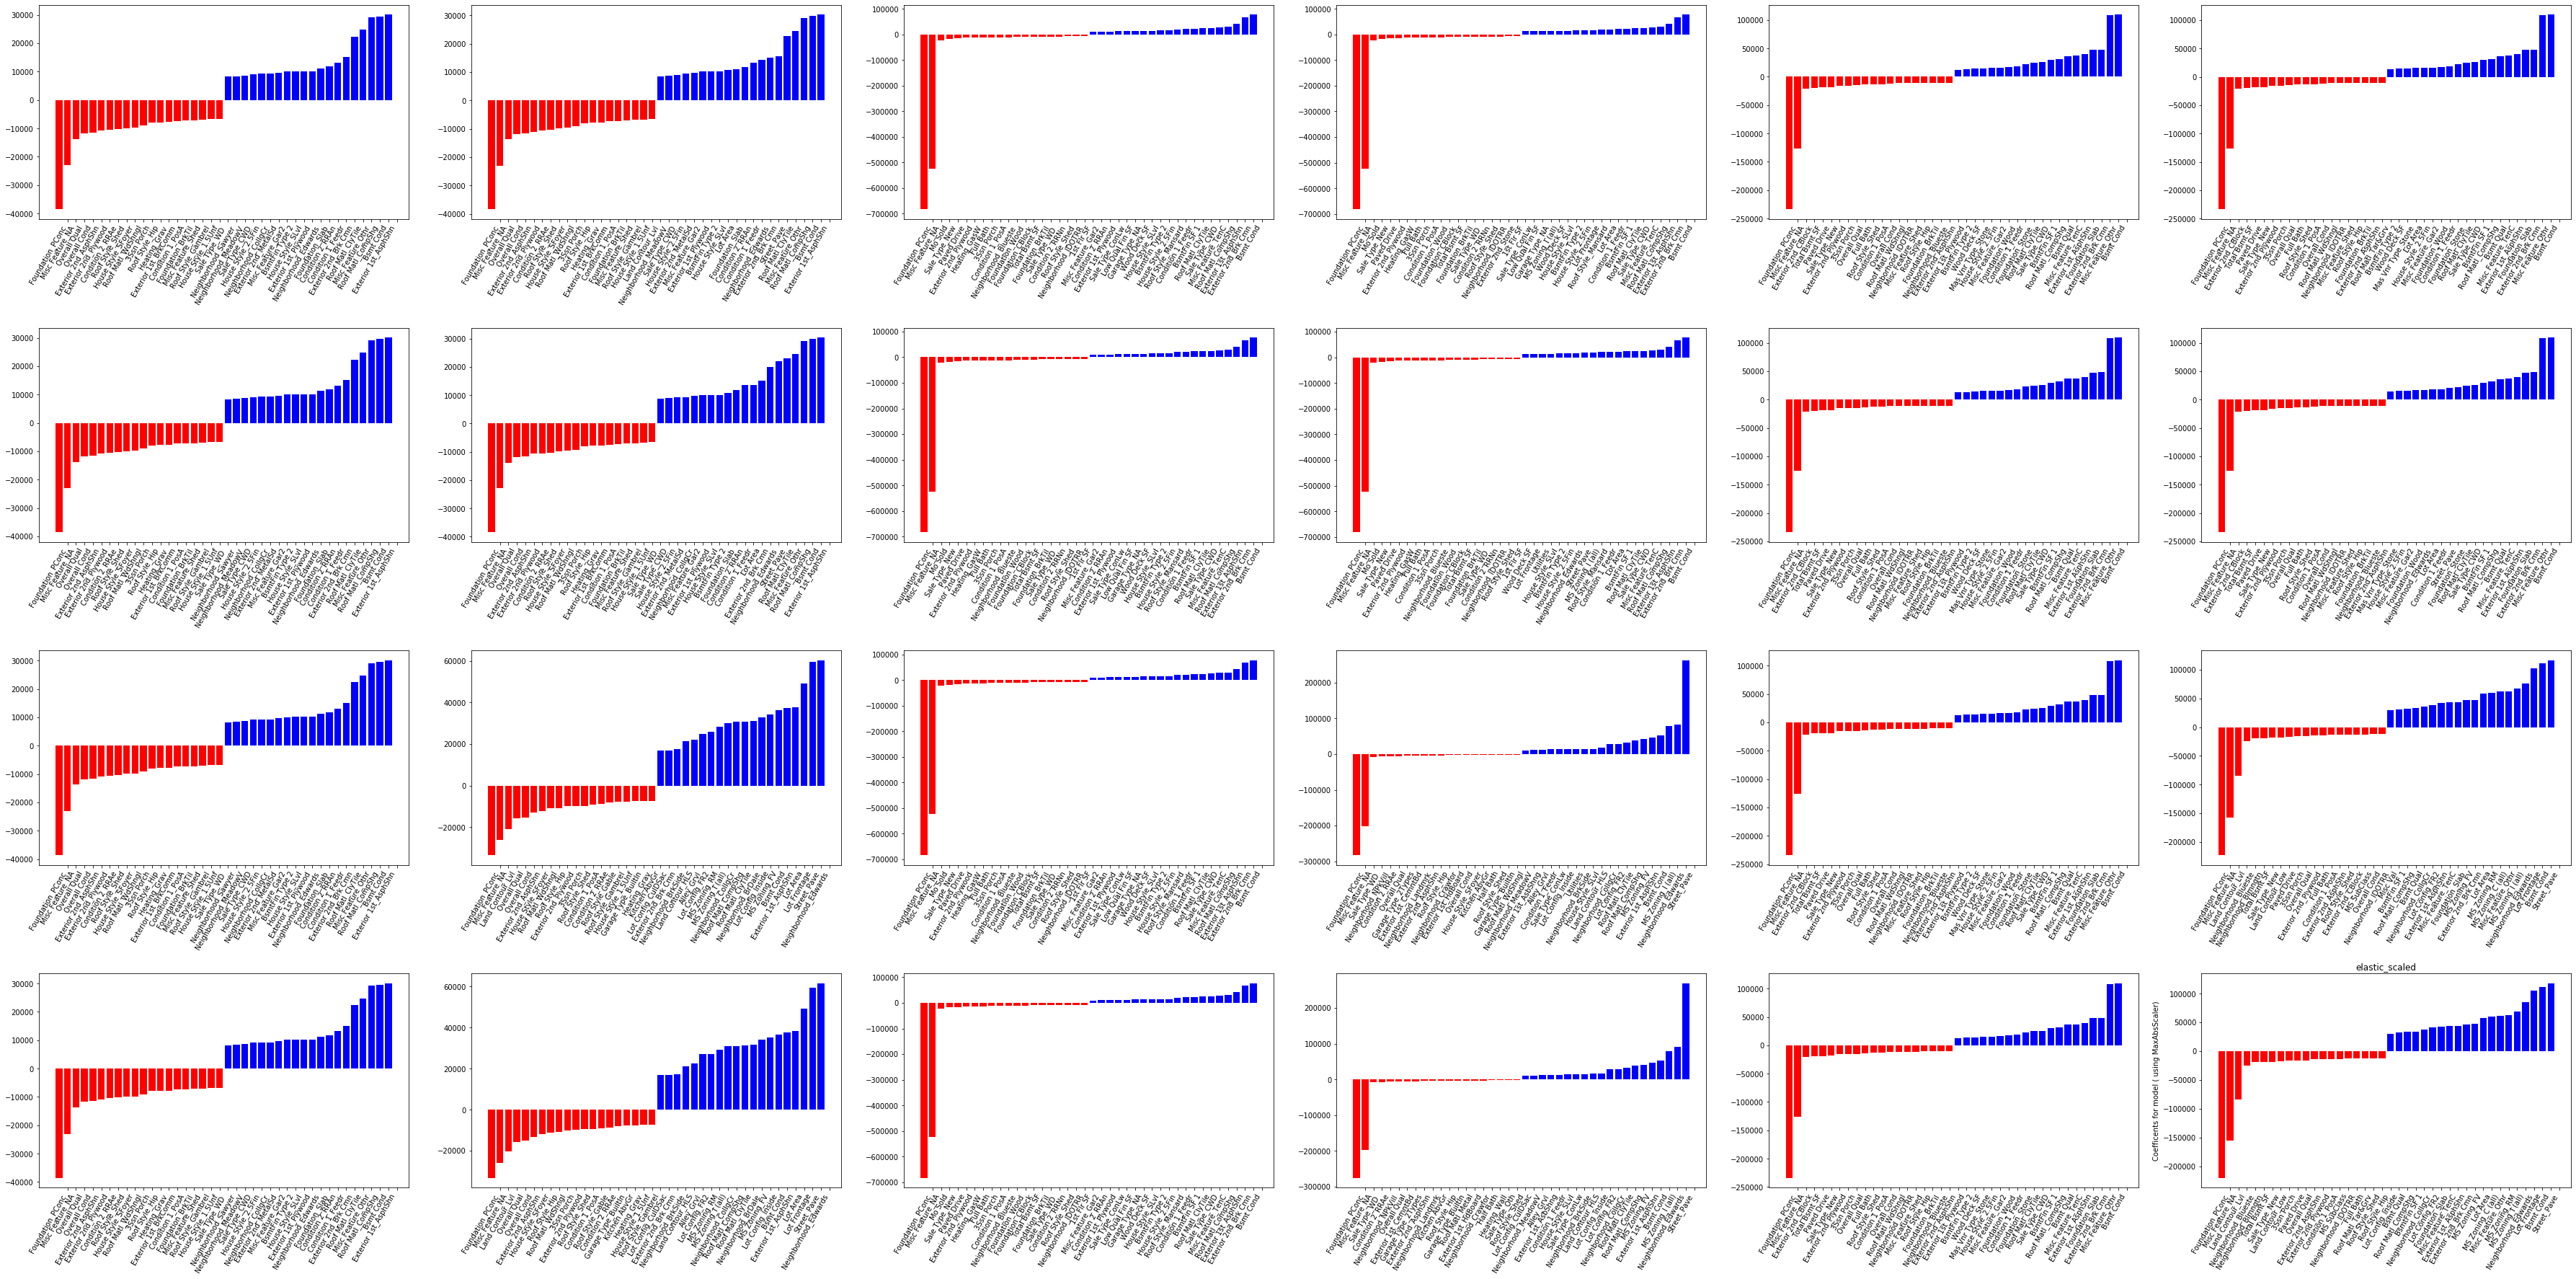

In [203]:

coef_fig, coef_ax = plt.subplots(colcnt,rowcnt,figsize=(50,25),sharey=False, sharex=False) #Coef visualization
def plot_coefficients(classifier, feature_names, ax, ax_r, ax_c, top_features=20): #modified visualizer function, originally from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
 coef = classifier.named_steps['classifier'].coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 ax[ax_r,ax_c].bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 fname = feature_names[top_coefficients]
 ax[ax_r,ax_c].set_xticks(np.arange(1, 1 + 2 * top_features))
 ax[ax_r,ax_c].set_xticklabels(fname, rotation=60, ha='right')

r=0
for scaler_str in grid_models:
  c = 0
  for model in grid_models[scaler_str]:
    feat_names = np.array(all_feats)
    plot_coefficients(model.best_estimator_,feat_names,coef_ax,r,c,20)
    if c ==0:
      coef_ax[crow,ccol].set_ylabel("Coefficents for model ( using " + scaler_str + ")")
    coef_ax[crow,ccol].set_title(label=grid_models.index.values[c])
    c +=1
  r += 1 
coef_fig.tight_layout(pad=2)
plt.show()


The Cooefficents across models tended to be the same, albeit with different scales, assumingly due to the different internal workings of each model. So yes, the models seem to agree that the same few features tend to be important, albeit with different orders/levels of importance. 



Now, one final score on the test datasets:

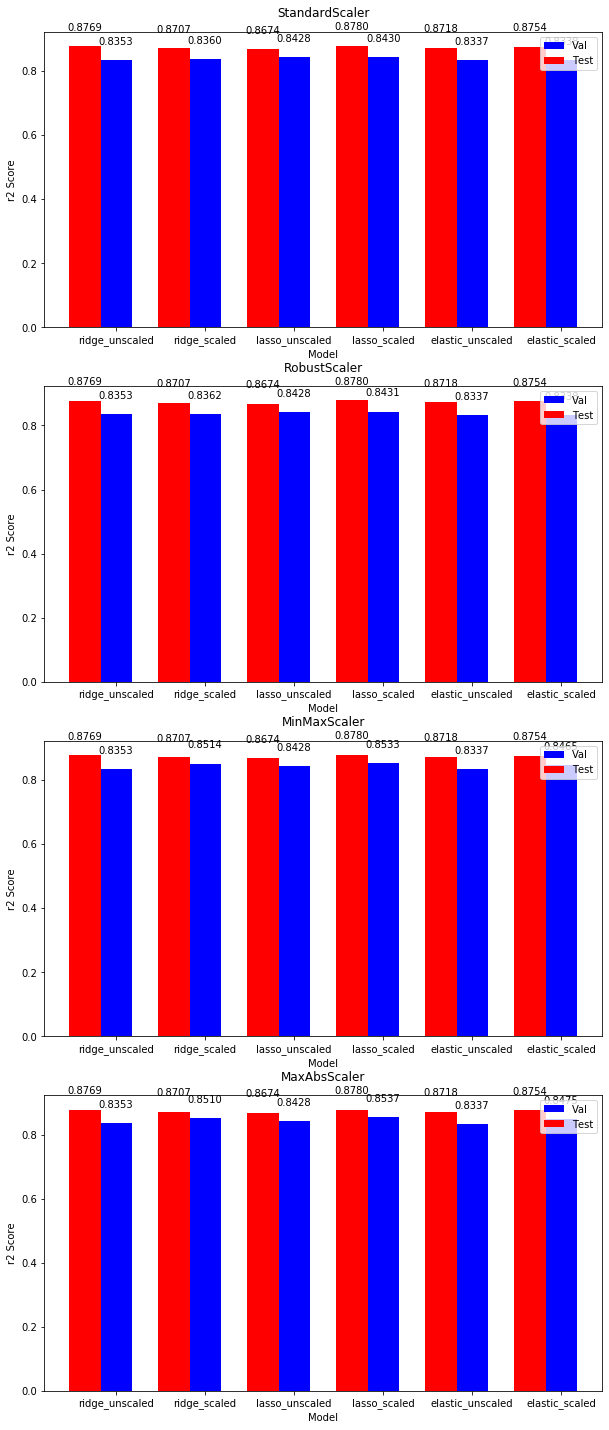

In [244]:
model_test_results = {}
model_val_results = {}
ftest_fig, ftest_ax = plt.subplots(colcnt,1,figsize=(10,25),sharey=False, sharex=False)

def autolabel(rects,c): # From https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ftest_ax[c].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.4f' % height,
                ha='center', va='bottom')

for scaler_str in grid_models:
  c = 0
  model_test_results[scaler_str] = {}
  model_val_results[scaler_str] = {}
  for model in grid_models[scaler_str]:
    result_dict = {}
    model_name = grid_models.index.values[c]
    test_score = model.best_estimator_.score(x_test,y_test)
    val_score = model.best_score_
    model_test_results[scaler_str][model_name] = test_score
    model_val_results[scaler_str][model_name] = val_score
    c +=1

c = 0  
for scaler_str in model_test_results:
  brange = range(len(model_test_results[scaler_str]))
  tvals = list(model_test_results[scaler_str].values())
  bnames = list(model_test_results[scaler_str].keys())
  vvals = list(model_val_results[scaler_str].values())
  test_bars = ftest_ax[c].bar(brange,bvals,width = 0.35, tick_label=bnames, color = 'r')
  val_bars = ftest_ax[c].bar(np.array(brange)+0.35,vvals,width = 0.35,tick_label=bnames, color = 'b')
  ftest_ax[c].legend((val_bars[0], test_bars[0]), ('Val', 'Test'))
  ftest_ax[c].set_title(label=scaler_str,pad=15)
  ftest_ax[c].set_ylabel("r2 Score")
  ftest_ax[c].set_xlabel("Model")
  autolabel(val_bars,c)
  autolabel(test_bars,c)
  c +=1
plt.show()